In [1]:
import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
import shutil
from glob import glob
# Helper libraries
import matplotlib.pyplot as plt
import math
%matplotlib inline
print(tf.__version__)

2.1.0


In [2]:
data_root='/C:/Users/urshi/Documents/AML Project (Urshila Ravindran-19318009)/Dataset/'
path_positive_cases = os.path.join('/C:/Users/urshi/Documents/AML Project (Urshila Ravindran-19318009)/Dataset/CT_COVID/CT_COVID/')
path_negative_cases = os.path.join('/C:/Users/urshi/Documents/AML Project (Urshila Ravindran-19318009)/Dataset/CT_NonCOVID/CT_NonCOVID/')

In [ ]:
#jpg and png files of the dataset 

In [3]:
# jpg and png files
positive_images_ls = glob(os.path.join(path_positive_cases,"*.png"))

negative_images_ls = glob(os.path.join(path_negative_cases,"*.png"))
negative_images_ls.extend(glob(os.path.join(path_negative_cases,"*.jpg")))

In [4]:
covid = {'class': 'CT_COVID',
         'path': path_positive_cases,
         'images': positive_images_ls}

non_covid = {'class': 'CT_NonCOVID',
             'path': path_negative_cases,
             'images': negative_images_ls}

In [5]:
total_positive_covid = len(positive_images_ls)
total_negative_covid = len(negative_images_ls)
print("Total Positive Cases Covid19 images: {}".format(total_positive_covid))
print("Total Negative Cases Covid19 images: {}".format(total_negative_covid))

Total Positive Cases Covid19 images: 349
Total Negative Cases Covid19 images: 397


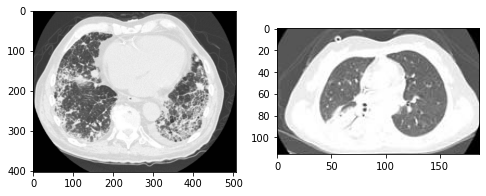

In [6]:
image_positive = cv2.imread(os.path.join(positive_images_ls[1]))
image_negative = cv2.imread(os.path.join(negative_images_ls[5]))

f = plt.figure(figsize=(8, 8))
f.add_subplot(1, 2, 1)
plt.imshow(image_negative)
f.add_subplot(1,2, 2)
plt.imshow(image_positive)

In [7]:
print("Image COVID Shape {}".format(image_positive.shape))
print("Image Non COVID Shape {}".format(image_negative.shape))

Image COVID Shape (116, 187, 3)
Image Non COVID Shape (403, 507, 3)


In [ ]:
#Create Train-Test Directory 

In [8]:
subdirs  = ['train/', 'test/']
for subdir in subdirs:
    labeldirs = ['CT_COVID', 'CT_NonCOVID']
    for labldir in labeldirs:
        newdir = subdir + labldir
        os.makedirs(newdir, exist_ok=True)

In [9]:
# Copy Images to test set

# seed random number generator
random.seed(123)
# define ratio of pictures used for testing 
test_ratio = 0.1


for cases in [covid, non_covid]:
    total_cases = len(cases['images']) #number of total images
    num_to_select = int(test_ratio * total_cases) #number of images to copy to test set
    
    print(cases['class'], num_to_select)
    
    list_of_random_files = random.sample(cases['images'], num_to_select) #random files selected

    for files in list_of_random_files:
        shutil.copy2(files, 'test/' + cases['class'])

CT_COVID 34
CT_NonCOVID 39


In [10]:
# Copy Images to train set
for cases in [covid, non_covid]:
    image_test_files = os.listdir('test/' + cases['class']) # list test files 
    for images in cases['images']:
        if images.split('/')[-1] not in (image_test_files): #exclude test files from shutil.copy
            shutil.copy2(images, 'train/' + cases['class'])

In [11]:
total_train_covid = len(os.listdir('/C:/Users/urshi/Documents/AML Project (Urshila Ravindran-19318009)/Dataset/train/CT_COVID'))
total_train_noncovid = len(os.listdir('/C:/Users/urshi/Documents/AML Project (Urshila Ravindran-19318009)/Dataset/train/CT_NonCOVID'))
total_test_covid = len(os.listdir('/C:/Users/urshi/Documents/AML Project (Urshila Ravindran-19318009)/Dataset/test/CT_COVID'))
total_test_noncovid = len(os.listdir('/C:/Users/urshi/Documents/AML Project (Urshila Ravindran-19318009)/Dataset/test/CT_NonCOVID'))


print("Train sets images COVID: {}".format(total_train_covid))
print("Train sets images Non COVID: {}".format(total_train_noncovid))
print("Test sets images COVID: {}".format(total_test_covid))
print("Test sets images Non COVID: {}".format(total_test_noncovid))

Train sets images COVID: 315
Train sets images Non COVID: 358
Test sets images COVID: 34
Test sets images Non COVID: 39


In [ ]:
#CNN Model

In [12]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [13]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [14]:
train_dir = os.path.join('/C:/Users/urshi/Documents/AML Project (Urshila Ravindran-19318009)/Dataset/train')
test_dir = os.path.join('/C:/Users/urshi/Documents/AML Project (Urshila Ravindran-19318009)/Dataset/test')
total_train = total_train_covid + total_train_noncovid
total_test = total_test_covid + total_test_noncovid

In [15]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 673 images belonging to 2 classes.


In [16]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 73 images belonging to 2 classes.


In [17]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [20]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps=total_test // batch_size
)

Train for 5 steps, validate for 1 steps
Epoch 1/15
5/5 [==============================] - 6s 1s/step - loss: 1.9535 - accuracy: 0.5284 - val_loss: 0.8752 - val_accuracy: 0.5616
Epoch 2/15
5/5 [==============================] - 3s 598ms/step - loss: 0.7382 - accuracy: 0.5615 - val_loss: 0.6824 - val_accuracy: 0.4932
Epoch 3/15
5/5 [==============================] - 3s 640ms/step - loss: 0.6322 - accuracy: 0.5431 - val_loss: 0.6991 - val_accuracy: 0.5479
Epoch 4/15
5/5 [==============================] - 3s 654ms/step - loss: 0.5956 - accuracy: 0.6367 - val_loss: 0.6859 - val_accuracy: 0.6027
Epoch 5/15
5/5 [==============================] - 4s 715ms/step - loss: 0.5658 - accuracy: 0.6703 - val_loss: 0.6791 - val_accuracy: 0.6027
Epoch 6/15
5/5 [==============================] - 3s 598ms/step - loss: 0.4886 - accuracy: 0.7468 - val_loss: 0.6664 - val_accuracy: 0.6027
Epoch 7/15
5/5 [==============================] - 3s 637ms/step - loss: 0.4397 - accuracy: 0.7358 - val_loss: 0.7307 - val_

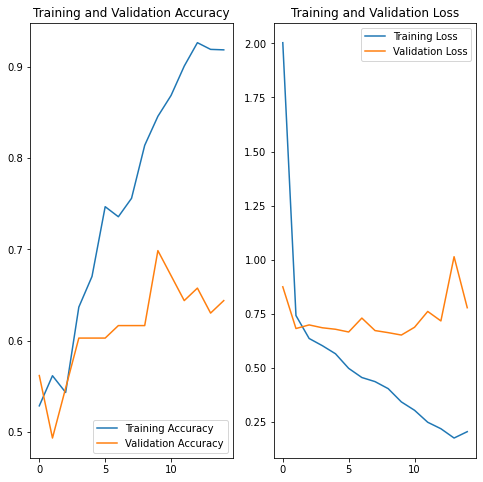

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()